# Nicholas W.: Forecasting Consensus Expectations of Nonfarm Payrolls (NFP)
## Data Exploration + Experiments

> **Purpose:** Explore forecast errors and cross-sectional dispersion to inform model choice and interval calibration.

**Inputs**
- `../out/data/nfp_df.parquet` and `../out/data/nfp_df_full.parquet` (from exported parquets from data preprocessing pipeline in *NFP_data.ipynb*)

**Index of checks & experiments**
- **C1 – Rolling RMSE of crowd median:** Build one-row-per-release table; plot 6-month rolling RMSE. Visualize regime-awareness.
- **C2 – Contiguity coverage:** Count active economists meeting strict 6/12/24-month presence. Check appropriate strictness of filter while keeping sufficient forecasters.
- **C3 – Error distributions:** Histograms + QQ plots for all forecast errors and median-errors.
- **C4 – Normality test:** Jarque–Bera test on median-errors.
- **C5 – Student-t GOF:** Fit t; KS and Cramér–von Mises tests on errors & median-errors.
- **C6 – Fitted t overlays:** Overlay fitted t-PDFs on histograms (both series).
- **C7 – Tail contribution:** RMSE build-up curve from largest absolute errors.
- **C8 – Spread vs |median error|:** Correlations (Pearson/Spearman) and scatter with trend.
- **C9 – Regressions:** |error| on spread in log–log and levels (HAC standard errors).
- **C10 – Coverage via t-fits:** Empirical vs nominal coverage from (i) cross-sectional t and (ii) rolling time-series t; report Mean-Absolute Gap (MAG).

**Outputs**
- Diagnostic plots and printed tables summarizing fit, tail risk, spread-error linkage, and coverage quality.


**Imports**

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as st          # t.fit, kstest, cramervonmises, pdf, etc.
from scipy import stats           # pearsonr, spearmanr, norm.cdf 
import statsmodels.api as sm
from scipy.stats import jarque_bera
from tqdm.auto import tqdm

In [2]:
DATA_DIR      = os.getenv("NFP_DATA_DIR", "../out/data")
DF_FILE       = "nfp_df.parquet"
DF_FULL_FILE  = "nfp_df_full.parquet"

def _find_data_file(fname: str) -> str:
    """Look in ../out/data (new) then ../out (legacy)."""
    candidates = [os.path.join(DATA_DIR, fname), os.path.join("../out", fname)]
    for p in candidates:
        if os.path.exists(p):
            return p
    raise FileNotFoundError(f"Could not find {fname} in {candidates}")

df      = pd.read_parquet(_find_data_file(DF_FILE), engine="pyarrow")
df_full = pd.read_parquet(_find_data_file(DF_FULL_FILE), engine="pyarrow")

print("df shape     :", df.shape)
print("df_full shape:", df_full.shape)

df shape     : (17046, 10)
df_full shape: (19375, 10)


In [3]:
df_full.head()

,release_date,period,actual,median_forecast,economist,firm,forecast,asof,surprise,error
0,2003-06-06,2003-05-31,-17.0,-30.0,Alessandro Truppia,Aletti Gestielle Sgr Spa,-15.0,2003-06-04,13.0,2.0
1,2003-06-06,2003-05-31,-17.0,-30.0,Alison Lynn Reaser,Point Loma Nazarene University,-15.0,2003-05-30,13.0,2.0
2,2003-06-06,2003-05-31,-17.0,-30.0,Anthony Chan,JPMorgan Chase Bank,-70.0,2003-05-30,13.0,-53.0
3,2003-06-06,2003-05-31,-17.0,-30.0,Aurelio Maccario,UniCredit Spa,-9.0,2003-05-30,13.0,8.0
4,2003-06-06,2003-05-31,-17.0,-30.0,Avery Shenfeld,Canadian Imperial Bank of Commerce,-20.0,2003-05-30,13.0,-3.0


**C1: Check historical error distribution (regime awareness)**

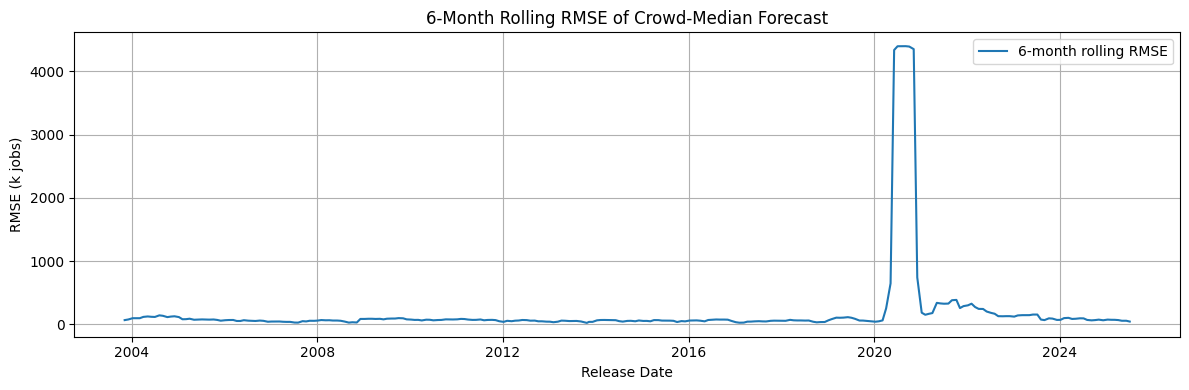

In [4]:
# Build one-row-per-release table of median forecast vs actual
median_vs_actual = (
    df_full.groupby("release_date")
           .agg(crowd_median=("forecast", "median"),
                actual      =("actual",   "first"))
           .dropna()
           .sort_index()
)

# Compute forecast error and rolling RMSE
median_vs_actual["err"] = median_vs_actual["crowd_median"] - median_vs_actual["actual"]

WINDOW = 6                       
median_vs_actual[f"rmse_{WINDOW}m"] = (
    median_vs_actual["err"]
      .rolling(WINDOW, min_periods=WINDOW)
      .apply(lambda x: np.sqrt(np.mean(x**2)), raw=True)
)

# Plot rolling RMSE of the crowd median
plt.figure(figsize=(12, 4))
plt.plot(median_vs_actual.index,
         median_vs_actual[f"rmse_{WINDOW}m"],
         label=f"{WINDOW}-month rolling RMSE")

plt.title(f"{WINDOW}-Month Rolling RMSE of Crowd-Median Forecast")
plt.xlabel("Release Date")
plt.ylabel("RMSE (k jobs)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**C2: Check contiguity filter economist coverage**

Contiguity windows:   0%|          | 0/3 [00:00<?, ?it/s]

6-mo tracking:   0%|          | 0/261 [00:00<?, ?it/s]

12-mo tracking:   0%|          | 0/255 [00:00<?, ?it/s]

24-mo tracking:   0%|          | 0/243 [00:00<?, ?it/s]

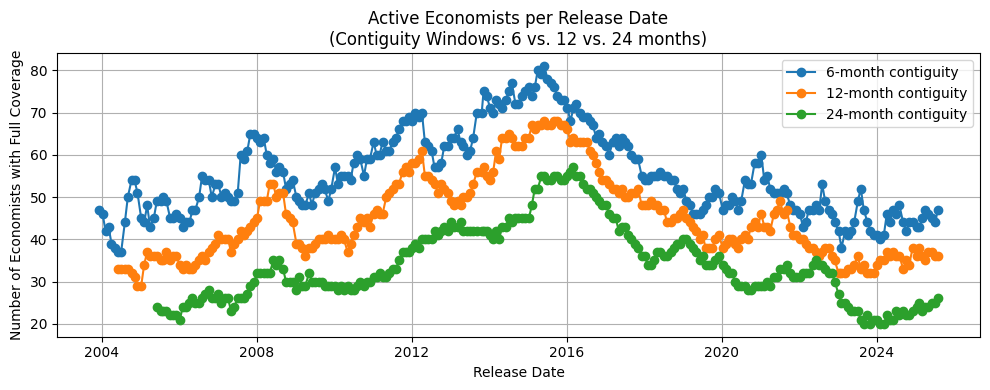

In [5]:
# prepare dates
dates = sorted(df_full["release_date"].unique())

contiguity_windows = [6, 12, 24]
active_counts = {}

for window in tqdm(contiguity_windows, desc="Contiguity windows"):
    counts = []
    for idx in tqdm(range(window, len(dates)),
                    desc=f"{window}-mo tracking", leave=False):
        t            = dates[idx]
        window_dates = dates[idx-window:idx]
        hist         = df_full[df_full["release_date"].isin(window_dates)]

        # strict contiguity: economist must appear in *every* month
        coverage = (
            hist.groupby("economist")["release_date"]
                .nunique()
        )
        valid_econs = coverage[coverage == window]

        counts.append((t, len(valid_econs)))

    active_counts[window] = pd.Series(
        [c for (_, c) in counts],
        index=[d for (d, _) in counts]
    )

    
plt.figure(figsize=(10, 4))
for window, series in active_counts.items():
    plt.plot(
        series.index,
        series.values,
        marker='o',
        label=f"{window}-month contiguity"
    )

plt.title("Active Economists per Release Date\n(Contiguity Windows: 6 vs. 12 vs. 24 months)")
plt.xlabel("Release Date")
plt.ylabel("Number of Economists with Full Coverage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**C3: Visualize error distribution (forecasts, consensus medians)**

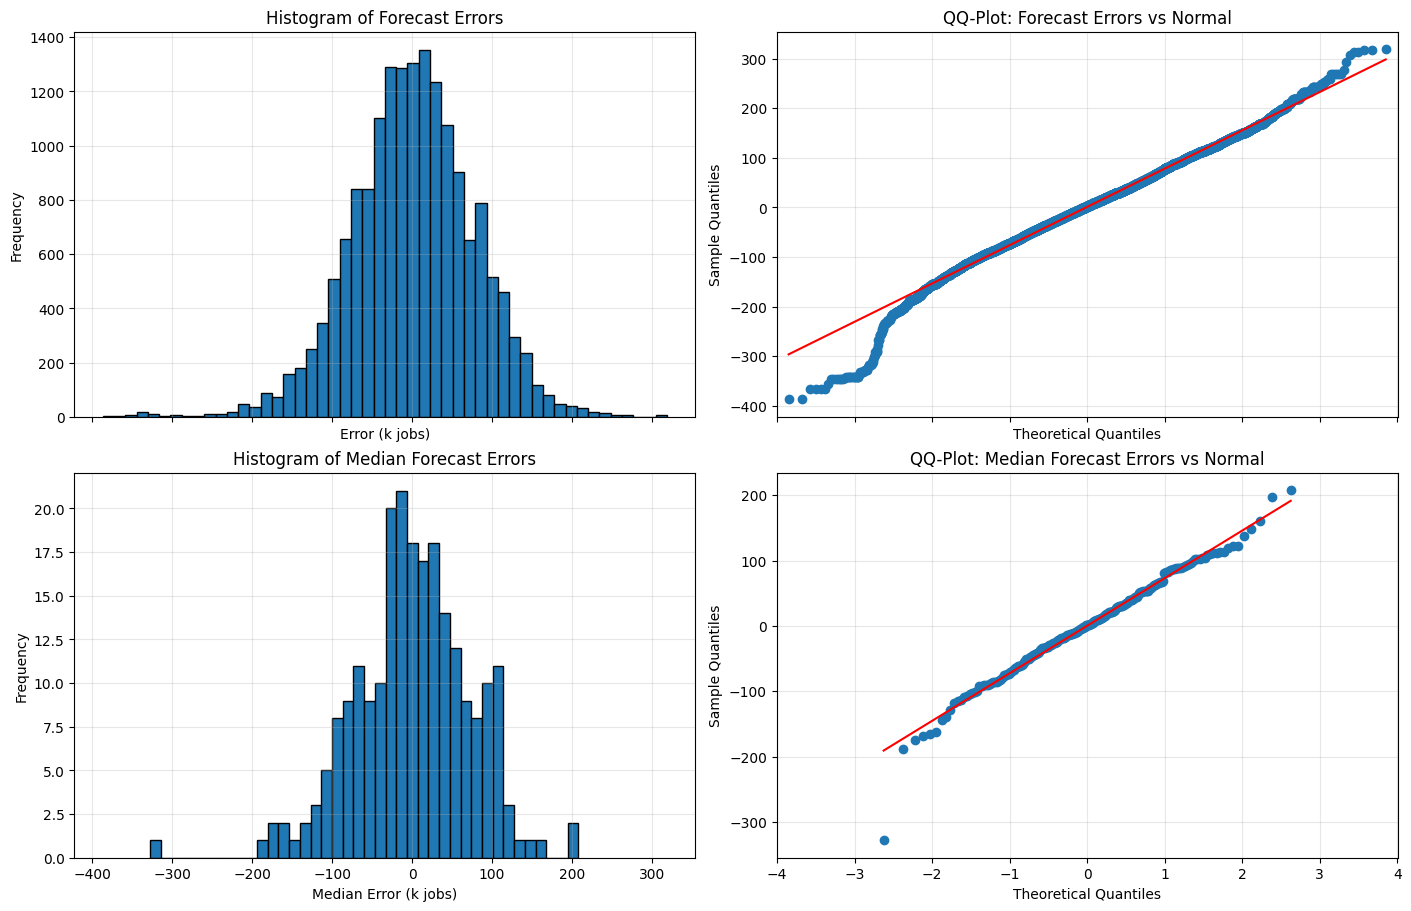

In [6]:
# Errors (all forecasts)
errors = df["error"].dropna().to_numpy()

# Median forecast errors (one per release)
median_errors = (
    df.drop_duplicates("release_date")
      .assign(median_err=lambda d: d["median_forecast"] - d["actual"])
      ["median_err"]
      .dropna()
      .to_numpy()
)

# Plot 2×2: hist + QQ for each series
fig, axs = plt.subplots(2, 2, figsize=(14, 9), constrained_layout=True, sharex="col")

# Top-left: Histogram of forecast errors
axs[0, 0].hist(errors, bins=50, edgecolor="black")
axs[0, 0].set_title("Histogram of Forecast Errors")
axs[0, 0].set_xlabel("Error (k jobs)")
axs[0, 0].set_ylabel("Frequency")
axs[0, 0].grid(True, alpha=0.3)

# Top-right: QQ plot of forecast errors vs Normal
sm.ProbPlot(errors).qqplot(line="s", ax=axs[0, 1])
axs[0, 1].set_title("QQ-Plot: Forecast Errors vs Normal")
axs[0, 1].grid(True, alpha=0.3)

# Bottom-left: Histogram of median forecast errors
axs[1, 0].hist(median_errors, bins=40, edgecolor="black")
axs[1, 0].set_title("Histogram of Median Forecast Errors")
axs[1, 0].set_xlabel("Median Error (k jobs)")
axs[1, 0].set_ylabel("Frequency")
axs[1, 0].grid(True, alpha=0.3)

# Bottom-right: QQ plot of median forecast errors vs Normal
sm.ProbPlot(median_errors).qqplot(line="s", ax=axs[1, 1])
axs[1, 1].set_title("QQ-Plot: Median Forecast Errors vs Normal")
axs[1, 1].grid(True, alpha=0.3)

plt.show()


**C4: Normality tests**

In [7]:
# --- Jarque-Bera on MEDIAN forecast errors -------------------------
jb_m_stat, jb_m_p = jarque_bera(median_errors)
print(f"Jarque–Bera (median errors)        :  JB = {jb_m_stat:,.2f},  p = {jb_m_p:.4f}")

if jb_m_p < 0.05:
    print("→ Reject normality of median errors at the 5 % level.")
else:
    print("→ Cannot reject normality of median errors at the 5 % level.")

Jarque–Bera (median errors)        :  JB = 22.63,  p = 0.0000
→ Reject normality of median errors at the 5 % level.


**C5: Student-t distribution statistical signficance test (KS, CvM)**

In [8]:
# --- Student-t GOF tests: errors & median_errors ---
def t_gof_tests(data, label):
    # Fit Student-t
    nu_hat, loc_hat, scale_hat = st.t.fit(data)
    
    # KS test
    ks_stat, ks_p = st.kstest(data, 't', args=(nu_hat, loc_hat, scale_hat))
    
    # CvM test
    t_cdf = lambda x: st.t.cdf(x, df=nu_hat, loc=loc_hat, scale=scale_hat)
    cvm_res = st.cramervonmises(data, t_cdf)
    
    # results
    print(f"{label} – fitted Student-t parameters: ν={nu_hat:.2f}, μ={loc_hat:.2f}, σ={scale_hat:.2f}")
    print(f"  KS test:  D = {ks_stat:.3f},  p = {ks_p:.4f}")
    print(f"  CvM test: W² = {cvm_res.statistic:.3f},  p = {cvm_res.pvalue:.4f}")
    
    if ks_p < 0.05 or cvm_res.pvalue < 0.05:
        print(f"  → Reject Student-t fit at 5% level (at least one test rejects).\n")
    else:
        print(f"  → Cannot reject Student-t fit at 5% level (both tests fail to reject).\n")

# Run for both datasets
t_gof_tests(errors, "Forecast errors")
t_gof_tests(median_errors, "Median forecast errors")

Forecast errors – fitted Student-t parameters: ν=10.37, μ=1.70, σ=69.27
  KS test:  D = 0.012,  p = 0.0182
  CvM test: W² = 0.191,  p = 0.2852
  → Reject Student-t fit at 5% level (at least one test rejects).

Median forecast errors – fitted Student-t parameters: ν=10.26, μ=1.49, σ=65.13
  KS test:  D = 0.036,  p = 0.9143
  CvM test: W² = 0.022,  p = 0.9947
  → Cannot reject Student-t fit at 5% level (both tests fail to reject).



**C6: Overlay fitted t PDF (Forecast errors, median errors)**

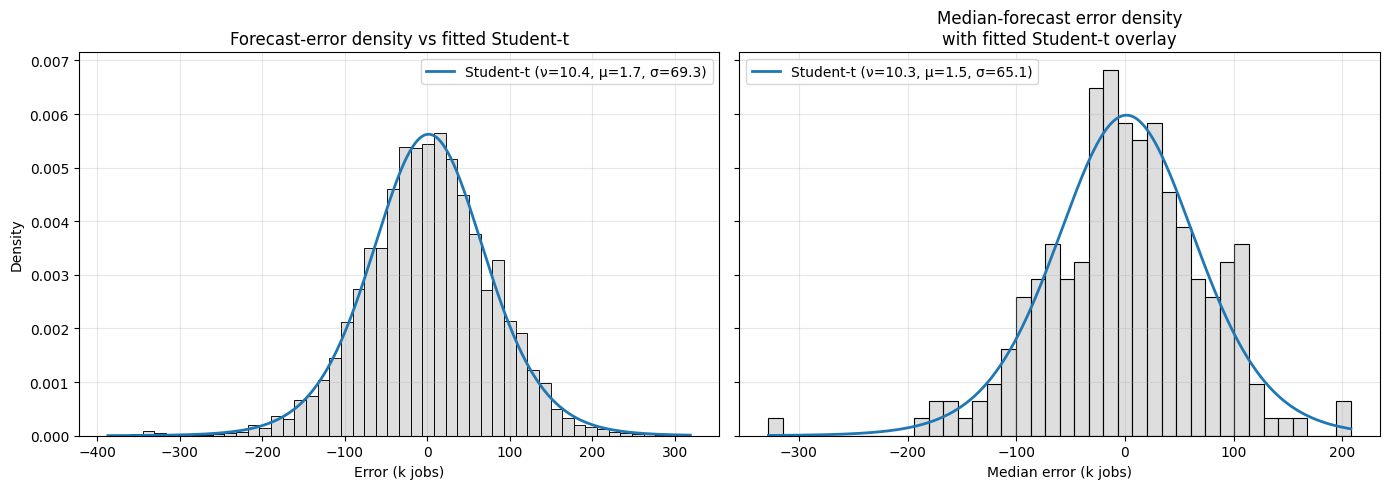

In [9]:
# === Student-t histogram + PDF overlays for errors & median_errors ===
def _fit_t_and_grid(x, ngrid=400):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    nu, loc, scale = st.t.fit(x)
    xgrid = np.linspace(x.min(), x.max(), ngrid)
    pdf   = st.t.pdf(xgrid, df=nu, loc=loc, scale=scale)
    return x, (nu, loc, scale), (xgrid, pdf)

# Fit & prepare both series
errs, (nu_e, mu_e, sig_e), (grid_e, pdf_e) = _fit_t_and_grid(errors)
meds, (nu_m, mu_m, sig_m), (grid_m, pdf_m) = _fit_t_and_grid(median_errors)

# Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Left: overall forecast errors
sns.histplot(errs, bins=50, stat="density", edgecolor="k", color="lightgray", ax=axs[0])
axs[0].plot(grid_e, pdf_e, lw=2, label=f"Student-t (ν={nu_e:.1f}, μ={mu_e:.1f}, σ={sig_e:.1f})")
axs[0].set_title("Forecast-error density vs fitted Student-t")
axs[0].set_xlabel("Error (k jobs)")
axs[0].set_ylabel("Density")
axs[0].legend()
axs[0].grid(alpha=0.3)

# Right: median forecast errors
sns.histplot(meds, bins=40, stat="density", edgecolor="k", color="lightgray", ax=axs[1])
axs[1].plot(grid_m, pdf_m, lw=2, label=f"Student-t (ν={nu_m:.1f}, μ={mu_m:.1f}, σ={sig_m:.1f})")
axs[1].set_title("Median-forecast error density\nwith fitted Student-t overlay")
axs[1].set_xlabel("Median error (k jobs)")
axs[1].legend()
axs[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

**C7: Contribution of tails to RMSE**

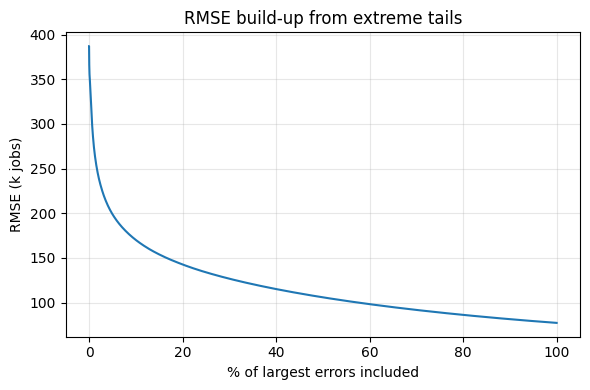

In [10]:
abs_err = np.abs(errors)
sorted_abs = np.sort(abs_err)[::-1]           # biggest first
cum_mse = np.cumsum(sorted_abs**2)
cum_rmse = np.sqrt(cum_mse / np.arange(1,len(errors)+1))

plt.figure(figsize=(6,4))
plt.plot(np.arange(1,len(errors)+1)/len(errors)*100, cum_rmse)
plt.xlabel("% of largest errors included"); plt.ylabel("RMSE (k jobs)")
plt.title("RMSE build-up from extreme tails"); plt.grid(alpha=.3); plt.tight_layout(); plt.show()

**C8: Cross-Sectional Spread vs Median Errors**


COVID panel:
  Pearson  r =  0.168  (p = 0.0105)
  Spearman ρ =  0.182  (p = 0.0057)

Full panel:
  Pearson  r =  0.710  (p = 0.0000)
  Spearman ρ =  0.347  (p = 0.0000)


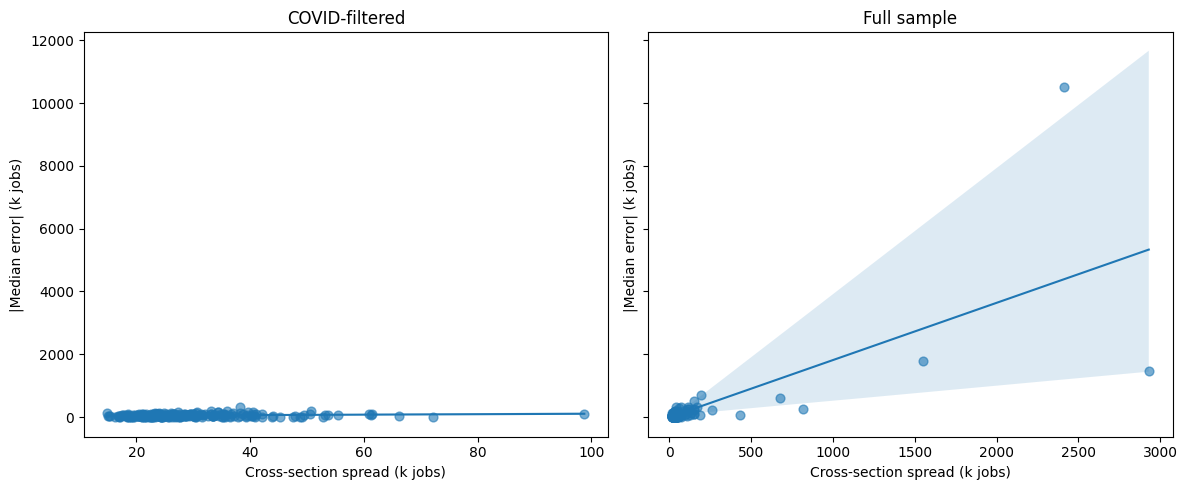

In [11]:
# Helper to build (date, spread, abs_err) table
def build_spread_df(panel: pd.DataFrame, label: str) -> pd.DataFrame:
    """Return DataFrame with release_date, spread, abs_err for a panel."""
    # cross-sectional std of forecasts
    spread = (panel.groupby("release_date")["forecast"]
                     .std(ddof=0)                # population SD
                     .rename("spread"))
    # median forecast & actual
    med_act = (panel.groupby("release_date")
                     .agg(median_fc=("forecast", "median"),
                          actual    =("actual",   "first")))
    med_act["abs_err"] = (med_act["median_fc"] - med_act["actual"]).abs()
    out = med_act.join(spread).reset_index()
    out["panel"] = label
    return out.dropna(subset=["spread", "abs_err"])         # ensure SD defined

covid_tbl  = build_spread_df(df,       "COVID")
full_tbl   = build_spread_df(df_full,  "Full")

# Correlation summary
for tbl, name in [(covid_tbl, "COVID"), (full_tbl, "Full")]:
    pearson  = stats.pearsonr(tbl["spread"], tbl["abs_err"])
    spearman = stats.spearmanr(tbl["spread"], tbl["abs_err"])
    print(f"\n{name} panel:")
    print(f"  Pearson  r = {pearson.statistic:6.3f}  (p = {pearson.pvalue:.4f})")
    print(f"  Spearman ρ = {spearman.statistic:6.3f}  (p = {spearman.pvalue:.4f})")


# Scatter plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, tbl, title in zip(axs, [covid_tbl, full_tbl], ["COVID-filtered", "Full sample"]):
    sns.regplot(data=tbl, x="spread", y="abs_err",
                scatter_kws={"alpha":0.6, "s":40}, line_kws={"linewidth":1.5}, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Cross-section spread (k jobs)")
    ax.set_ylabel("|Median error| (k jobs)")

plt.tight_layout()
plt.show()

**C9: Regression Test**

Level and log regressions.

ln | error_t | = beta_0 + beta_1 * ln(spread_t) + epsilon_t

In [12]:
def run_err_vs_spread(df, name: str, hac_lags: int = 12):
    """Filter, then run log–log and level regressions of abs_err on spread."""
    # Keep only required cols, positive values; drop NaN/Inf
    tbl = df[["spread", "abs_err"]].copy()
    tbl = tbl[(tbl["spread"] > 0) & (tbl["abs_err"] > 0)]
    tbl = tbl.replace([np.inf, -np.inf], np.nan).dropna(subset=["spread", "abs_err"])

    print(f"[{name}] Rows in regression: {len(tbl)}")
    if len(tbl) == 0:
        print(f"[{name}] No rows after filtering.")
        return None

    # --- log–log regression ---
    print(f"\nLog–log regression, {name}:")
    y_log = np.log(tbl["abs_err"].to_numpy())
    X_log = sm.add_constant(np.log(tbl["spread"].to_numpy()))
    ols_log = sm.OLS(y_log, X_log).fit(cov_type="HAC", cov_kwds={"maxlags": hac_lags})
    print(ols_log.summary())

    # --- level-level regression ---
    print(f"\nLevel regression, {name}:")
    y_lvl = tbl["abs_err"].to_numpy()
    X_lvl = sm.add_constant(tbl["spread"].to_numpy())
    ols_lvl = sm.OLS(y_lvl, X_lvl).fit(cov_type="HAC", cov_kwds={"maxlags": hac_lags})
    print(ols_lvl.summary())

    return {"filtered": tbl, "loglog": ols_log, "level": ols_lvl}

# ---- run for both tables ----
results = {}
for nm, df in [("Full panel", full_tbl), ("COVID panel", covid_tbl)]:
    results[nm] = run_err_vs_spread(df, nm, hac_lags=12)

[Full panel] Rows in regression: 264

Log–log regression, Full panel:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     113.9
Date:                Fri, 15 Aug 2025   Prob (F-statistic):           2.57e-22
Time:                        11:21:25   Log-Likelihood:                -392.73
No. Observations:                 264   AIC:                             789.5
Df Residuals:                     262   BIC:                             796.6
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------

**C10: Uncertainty quantification using information in the cross-section**

In [13]:
LEVELS  = [0.50, 0.60, 0.70, 0.80, 0.90, 0.95]
TS_WINS = [12, 24, 36, 60, 120]          # months
MIN_XS  = 5                          # min forecasts in cross-section
PANELS  = {"Full": df_full}

def _mean_abs_gap(empirical_vec, levels=LEVELS):
    """Mean-absolute gap between empirical and nominal coverages."""
    return float(np.abs(np.array(empirical_vec) - np.array(levels)).mean())

def in_band(center, sig, nu, level, actual):
    half = st.t.ppf(1 - (1-level)/2, df=nu) * sig
    return int(center - half <= actual <= center + half)

rows = []

for panel_name, panel in PANELS.items():

    # cross-section 
    xs_hits = {L: 0 for L in LEVELS};  xs_tot = 0

    for date, grp in tqdm(panel.groupby("release_date"), desc=f"{panel_name} XS"):
        sample = grp["forecast"].dropna().values
        act    = grp["actual"].iloc[0]
        if len(sample) < MIN_XS or np.isnan(act):
            continue
        nu, loc, sig = st.t.fit(sample)           # μ̂ = loc
        for L in LEVELS:
            xs_hits[L] += in_band(loc, sig, nu, L, act)
        xs_tot += 1
    
    emp_vec = [xs_hits[L] / xs_tot for L in LEVELS]   # six empirical coverages
    mag     = _mean_abs_gap(emp_vec) 

    for L, e in zip(LEVELS, emp_vec):
        rows.append({"Method": f"{panel_name}-XS-t",
                     "Nominal": L,
                     "Empirical": e,
                     "MAG": mag})

    # time-series
    ts_hits = {w:{L:0 for L in LEVELS} for w in TS_WINS}
    ts_tot  = {w:0 for w in TS_WINS}

    panel_sorted = panel.sort_values("release_date")
    err_series = (panel_sorted.groupby("release_date")
                                .apply(lambda g: g["median_forecast"].iloc[0] - g["actual"].iloc[0])
                                .dropna())
    dates = err_series.index.to_list()

    for win in TS_WINS:
        for i in tqdm(range(win, len(dates)), desc=f"{panel_name} TS {win}m", leave=False):
            train_errs = err_series.iloc[i-win:i].values
            if train_errs.size < win:
                continue
            nu, mu, sig = st.t.fit(train_errs)

            cur_date   = dates[i]
            slc        = panel_sorted[panel_sorted["release_date"] == cur_date]
            point_med  = slc["median_forecast"].iloc[0]   # center at median + μ̂
            actual_val = slc["actual"].iloc[0]
            if np.isnan(actual_val):
                continue

            center_ts  = point_med + mu                   # overall center
            for L in LEVELS:
                ts_hits[win][L] += in_band(center_ts, sig, nu, L, actual_val)
            ts_tot[win] += 1
            
        emp_vec_win = [ts_hits[win][L] / ts_tot[win] for L in LEVELS]
        mag_win     = _mean_abs_gap(emp_vec_win)

        for L, e in zip(LEVELS, emp_vec_win):
            rows.append({"Method": f"{panel_name}-TS-t_{win}m",
                         "Nominal": L,
                         "Empirical": e,
                         "MAG": mag_win})

df = pd.DataFrame(rows)

coverage_df = (df
               .pivot(index="Method", columns="Nominal", values="Empirical")
               .sort_index())

coverage_df["MAG"] = (df
                      .drop_duplicates("Method")
                      .set_index("Method")["MAG"]
                      .reindex(coverage_df.index))

print("\nEmpirical vs nominal coverage (XS/TS-t centred at μ̂)")
print(coverage_df.to_string(float_format=lambda x: f"{x:0.3f}"))

Full XS:   0%|          | 0/267 [00:00<?, ?it/s]

C:\Users\nwong\AppData\Local\Temp\ipykernel_31760\97383017.py:46: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g["median_forecast"].iloc[0] - g["actual"].iloc[0])


Full TS 12m:   0%|          | 0/254 [00:00<?, ?it/s]

Full TS 24m:   0%|          | 0/242 [00:00<?, ?it/s]

Full TS 36m:   0%|          | 0/230 [00:00<?, ?it/s]

Full TS 60m:   0%|          | 0/206 [00:00<?, ?it/s]

Full TS 120m:   0%|          | 0/146 [00:00<?, ?it/s]


Empirical vs nominal coverage (XS/TS-t centred at μ̂)
Nominal          0.5   0.6   0.7   0.8   0.9  0.95   MAG
Method                                                  
Full-TS-t_120m 0.425 0.534 0.623 0.733 0.822 0.918 0.066
Full-TS-t_12m  0.449 0.547 0.657 0.728 0.862 0.921 0.047
Full-TS-t_24m  0.475 0.566 0.674 0.748 0.893 0.942 0.025
Full-TS-t_36m  0.470 0.565 0.643 0.770 0.887 0.943 0.029
Full-TS-t_60m  0.427 0.539 0.670 0.733 0.888 0.937 0.043
Full-XS-t      0.233 0.289 0.368 0.425 0.496 0.586 0.342
